# Time to get your hands dirty! The irreducible mass of black holes.
For a BH of mass $M$ spin $\chi \in [0,1]$, the irreducible mass is

$$M_{\text{irr}} = M \sqrt{\frac{1 + \sqrt{1 - \chi^2}}{2}}$$

For convenience, let us define

$$f(\chi) = \sqrt{\frac{1 + \sqrt{1 - \chi^2}}{2}} = \frac{M_{\text{irr}}}{M}$$

Suppose you have repeated measurements of $M$ and $\chi$. This is just because we're still frequentists for now. When we will put our Bayesian hat on, these distributions will be the *posterior samples* from a single measurement.

Let's assume that:

- the spin $\chi$ is uniformly distributed between 0 and 1.
- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$.

These are simplistic assumptions that, however, are not too far from what we are now measuring with gravitational-wave detectors. It's a toy model, but not a totally unreasonable one.

Tasks:
1. Start with a value of $\sigma = 0.02$. Note that $\mu$ is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. Just set $\mu = 1$ in your code and remember that all masses in the problem are measured in units of $\mu$.

2. Plot the resulting pdf of $M_{\text{irr}}$. First try a histogram with one of the rules of thumb we've seen above.

   *Hint:* You don't know the functional form of the pdf of $M_{\text{irr}}$... but you don't need it if you just want to generate samples! That's the nice thing about numerics!

3. Using the same samples, plot the distribution of $M_{\text{irr}}$ using a KDE.

4. Compute the KS distance between $M_{\text{irr}}$ and $f$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

5. Compute the KS distance between $M_{\text{irr}}$ and $M$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

6. You should find that (i) $M_{\text{irr}}$ is distributed like $f$ if $\sigma \ll \mu$ and (ii) $M_{\text{irr}}$ is distributed like $M$ if $\sigma \gg \mu$.

7. [Optional, not examinable] Compute the pdf of $f$ from its mathematical definition (pen and paper!). Verify this result:

    $$\pi(f) = 2 \frac{2f^2 - 1}{\sqrt{1 - f^2}}.$$

8. Compute the pdfs of  $M_{\text{irr}}$ from its mathematical definitions (pen and paper!). Verify this result:

   $$p(M_{\text{irr}}) = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^{1} \exp \left[ -\frac{(M_{\text{irr}}/f - \mu)^2}{2\sigma^2} \right] \frac{2f^2 - 1}{f\sqrt{1 - f^2}} \mathrm{d}f.$$  

The this expression is only semi-analytic; that integral should then be solved numerically.

Hint (for point 8): You want to use this theorem for the product of two random variables.

9. Using the expressions from point 7 and 8, plot those pdfs check that they agree with your KDE reconstructions.

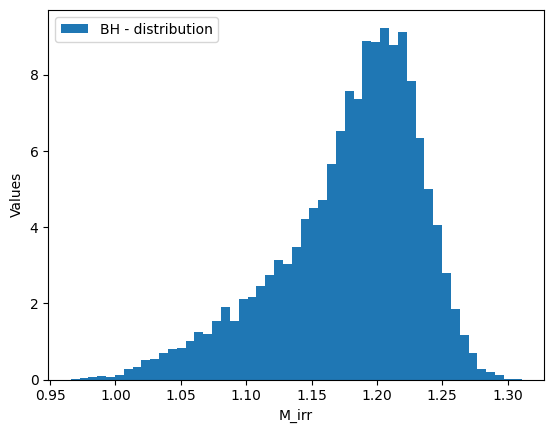

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astroML import stats as astroMLstats

N = 10000

sigma = 0.02
mu = 1
M = np.random.normal(mu, sigma, N)
chi = np.random.uniform(0,1,N)

M_irr = M * np.sqrt( 1+ np.sqrt(1-chi**2)/2) # by definition

sigmaG2 = astroMLstats.sigmaG(M_irr) # quantile at 75 - quantile at 25
binsize = 2.7 * sigmaG2 / (N**(1/3)) # Freedman-Diaconis
binsG = np.append( np.arange(start=M_irr.min(), stop=M_irr.max(), step=binsize) , M_irr.max()) 

plt.hist(M_irr, 51, density=True, label = "BH - distribution")
plt.xlabel("M_irr")
plt.ylabel("Values")
plt.legend()
plt.show()

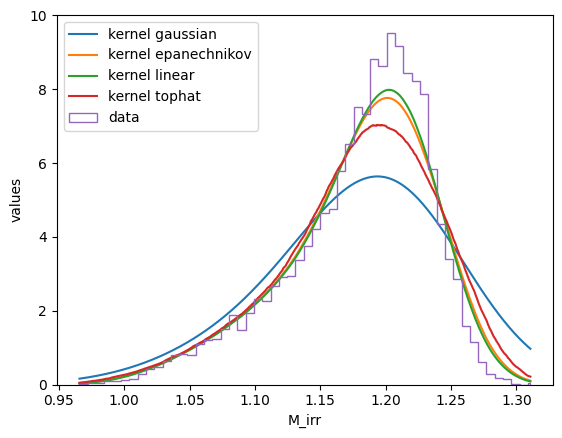

In [2]:
from sklearn.neighbors import KernelDensity

xgrid = np.linspace(M_irr.min(),M_irr.max(),1000)  

def kde (data, bandwidth, kernel):
    KDE = KernelDensity(bandwidth = bandwidth, kernel = kernel)
    KDE.fit(data[:, np.newaxis]) 
    log_pdf = KDE.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)


bandwidth = 0.05

pdf = kde (M_irr, bandwidth, kernel = "gaussian")       # normal distribution density function
pdf2 = kde (M_irr, bandwidth, kernel = "epanechnikov")  # parabolic with a fix support, more localized then the gaussian
pdf3 = kde (M_irr, bandwidth, kernel = "linear")        # linear decrescent weights at the distance of the referement point. less smooth then the gaussian
pdf4 = kde (M_irr, bandwidth, kernel = "tophat")        # kernel uniform, assign the same weight at all the point in a windows and zero outside. less utileze because it can generate less precise estimation

plt.plot(xgrid,pdf, label = "kernel gaussian")
plt.plot(xgrid,pdf2, label = "kernel epanechnikov")
plt.plot(xgrid,pdf3, label = "kernel linear")
plt.plot(xgrid,pdf4, label = "kernel tophat")

plt.hist(M_irr, binsG, label = "data", density= True, histtype="step")
plt.xlabel("M_irr")
plt.ylabel("values")
plt.legend()
plt.show()


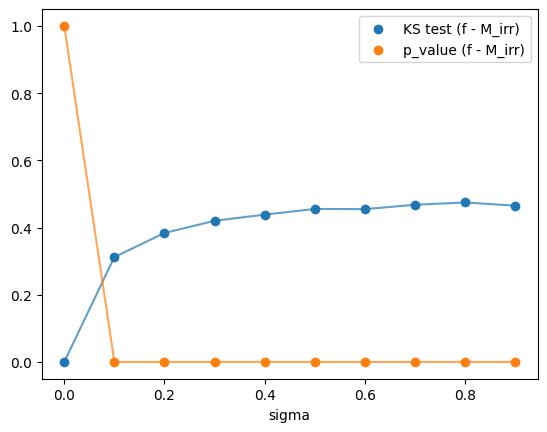

In [3]:
import scipy as sp

statistic = []
p_value = []
x = []

for i in range(10) :

    sigma =  i/10

    chi_1 = np.random.uniform(0,1,N)
    M = np.random.normal(mu, sigma, N)

    M_irr = M * np.sqrt(( 1+ np.sqrt(1-chi**2))/2)
    f = np.sqrt(( 1+ np.sqrt(1-chi**2))/2)

    statistic_i , p_value_i = sp.stats.ks_2samp(f , M_irr)

    #kstest: it makes the KS test on a campion in respect of the distribution.
    #ks_2samp: it's between two different distribution.

    statistic.append(statistic_i)
    p_value.append(p_value_i)

    x.append(sigma)


plt.scatter(x,statistic, label = "KS test (f - M_irr)")
plt.plot(x, statistic, linestyle="-", alpha=0.7)

plt.scatter(x, p_value, label = "p_value (f - M_irr)")
plt.plot(x, p_value, linestyle="-", alpha=0.7)

plt.xlabel("sigma")

plt.legend()
plt.show()


The KS test is designed to measure the maximum difference between two functions. <br>
As shown in the graph above, in the limit of $\sigma = 0$ (i.e., a Dirac delta), $M$ is a constant equal to $\mu$, and the KS test returns a value of 0 with a p-value of 1. This indicates that the two functions are exactly the same.<br>
As $\sigma$ increases, however, we quickly reach a saturation point, with the p-value dropping to nearly 0. This increase in the KS statistic signals a growing difference between the two distributions.<br>
When $\sigma$ becomes greater than 0.3, the KS statistic stabilizes around 0.4 / 0.45, suggesting that the difference between the distributions no longer increases significantly.<br>
The reason for this behavior lies in the definition of $f$, which does not depend on $\sigma$, while $M_{\text{irr}}$ is affected by it, since $M$ is Gaussian-distributed with a width of $\sigma$.<br>
Beyond 0.3, the dispersion of $M$ is large enough to make the two distributions significantly different. However, the difference between the distributions reaches a limit because the ratio $f$ remains confined within the same range of values, between 1 and 0.7 (as can be seen in the plot below).



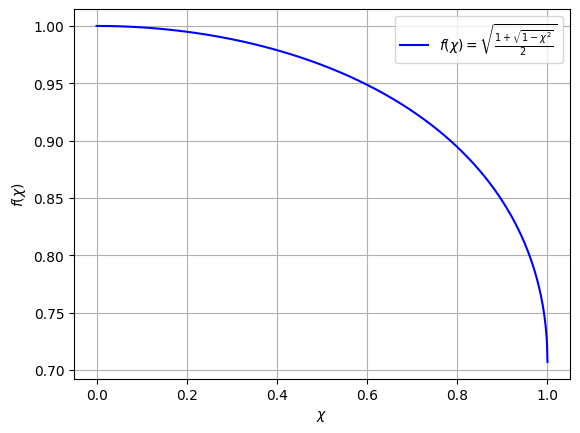

In [4]:
def fun(chi):
    return np.sqrt((1 + np.sqrt(1 - chi**2)) / 2)

chi_values = np.linspace(0, 1, 1000)
f_values = fun(chi_values)

plt.plot(chi_values, f_values, label=r'$f(\chi) = \sqrt{\frac{1 + \sqrt{1 - \chi^2}}{2}}$', color="blue")
plt.xlabel(r'$\chi$')
plt.ylabel(r'$f(\chi)$')
plt.grid(True)
plt.legend()
plt.show()

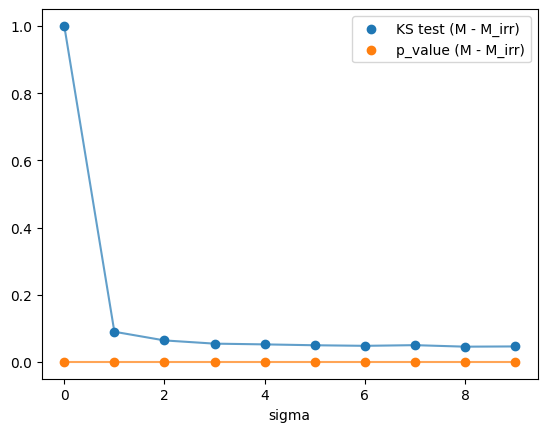

In [5]:
statistic = []
p_value_2 = []
x = []

for i in range(10) :

    sigma =  i
    chi = np.random.uniform(0,1,N)
    M = np.random.normal(mu, sigma, N)
    M_irr = M * np.sqrt( 1+ np.sqrt(1-chi**2)/2)

    statistic_i , p_value_i = sp.stats.ks_2samp(M , M_irr)

    statistic.append(statistic_i)
    p_value_2.append(p_value_i)

    x.append(sigma)


plt.scatter(x,statistic, label = "KS test (M - M_irr)")
plt.plot(x, statistic, linestyle="-", alpha=0.7)

plt.scatter(x, p_value_2, label = "p_value (M - M_irr)")
plt.plot(x, p_value_2, linestyle="-", alpha=0.7)

plt.xlabel("sigma")

plt.legend()
plt.show()

In the first test, we compared the distribution of the ratio with that of $M_{\text{irr}}$.
In the second test, it was compared directly with $M$.
This transformation introduces a point-by-point multiplication on $M$ that depends on $\chi$, and therefore modifies the shape of the distribution.

For small values of $\sigma$, $M$ is highly concentrated around $\mu$, and the transformation introduces a significant distortion, making the distribution very different from that of $M$. The KS statistic is high and the p-value is low.

For large values of $\sigma$, on the other hand, $M$ is widely spread, and the point-by-point multiplication with the factor $f$ has a relatively smaller effect.
The two distributions tend to resemble each other, with a decreasing KS statistic.

As for the p-value, in the KS test it indicates how likely it is to obtain a distance between the distributions at least as large as the observed one, assuming the two distributions are actually the same. When $N$ is large (in our case 10,000), even a small distance between distributions results in a KS statistic that may be small in absolute value, but still leads to a numerically zero p-value.
You can print the value and observe how it grows.




/tmp/ipykernel_17205/3622065941.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(x,np.log(p_value_2), label = "p_value (M - M_irr)")
/tmp/ipykernel_17205/3622065941.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(p_value_2), linestyle="-", alpha=0.7)


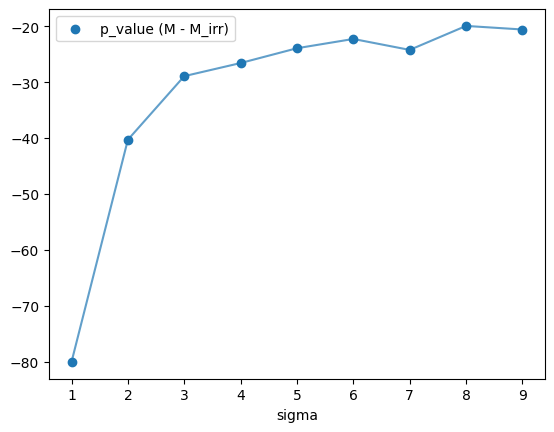

In [6]:
plt.scatter(x,np.log(p_value_2), label = "p_value (M - M_irr)")
plt.plot(x, np.log(p_value_2), linestyle="-", alpha=0.7)

#plt.scatter(x,np.log(p_value)/100, label = "p_value (f - M_irr)")
#plt.plot(x, np.log(p_value)/100, linestyle="-", alpha=0.7)
# non è plottabile perchè va identicamente a 0, già il primo punto è 10^-323 ...

plt.xlabel("sigma")

plt.legend()
plt.show()

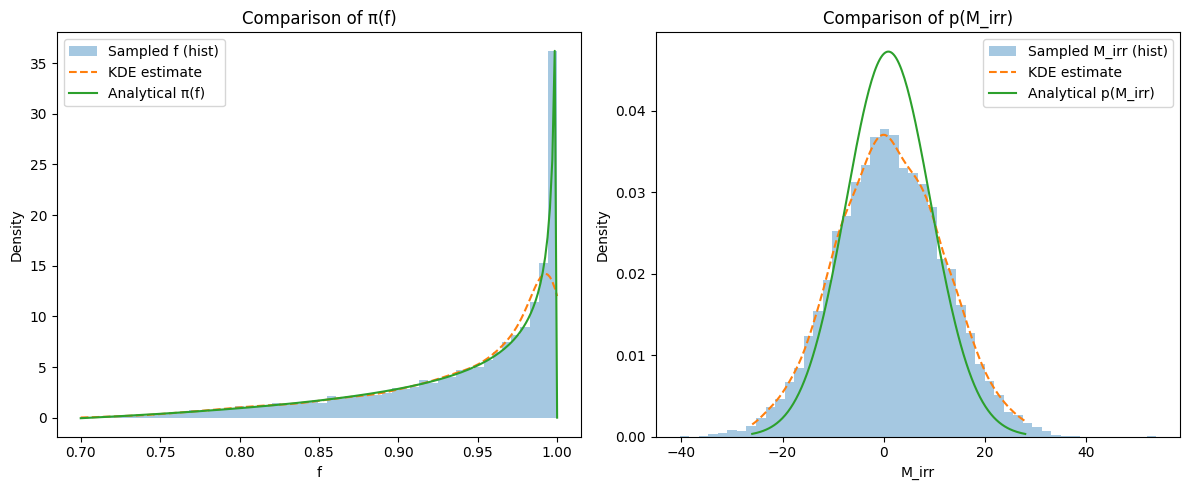

In [7]:
# this method calculete the PDF's of the data, by using KDE with a default sigma derived by scott's rule
kde_f = sp.stats.gaussian_kde(f)
kde_Mirr = sp.stats.gaussian_kde(M_irr)

# Definition of the analitic pdf of f
def pi_f(f):
    return 2 * (2*f**2 - 1) / np.sqrt(1 - f**2) if 0 < f < 1 else 0


f_vals = np.linspace(0.7, 1, 200)
pi_f_vals = np.array([pi_f(fi) for fi in f_vals])

# sigma = 0.02
# mu = 1

# definition of the analitic PDF of M_irr
def p_Mirr(M_irr, sigma, mu):
    integrand = lambda f: np.exp(-((M_irr / f - mu)**2) / (2 * sigma**2)) * (2*f**2 - 1) / (f * np.sqrt(1 - f**2)) #boh, è un modo di python per definire una funzione anonima
    norm_factor = np.sqrt(2 / np.pi) / sigma
    integral, _ = sp.integrate.quad(integrand, 1/np.sqrt(2), 1) #the function quad of SciPy calculate the integranl
    return norm_factor * integral

# calculate the pdf 
M_irr_vals = np.linspace(mu - 3*sigma, mu + 3*sigma, 200)
p_Mirr_vals = np.array([p_Mirr(Mi, sigma, mu) for Mi in M_irr_vals])

# Plot of f's distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(f, bins=50, density=True, alpha=0.4, label="Sampled f (hist)")
plt.plot(f_vals, kde_f(f_vals), label="KDE estimate", linestyle="dashed")
plt.plot(f_vals, pi_f_vals, label="Analytical π(f)", linestyle="solid")
plt.xlabel("f")
plt.ylabel("Density")
plt.legend()
plt.title("Comparison of π(f)")

# Plot of M_irr's distribution
plt.subplot(1, 2, 2)
plt.hist(M_irr, bins=50, density=True, alpha=0.4, label="Sampled M_irr (hist)")
plt.plot(M_irr_vals, kde_Mirr(M_irr_vals), label="KDE estimate", linestyle="dashed")
plt.plot(M_irr_vals, p_Mirr_vals, label="Analytical p(M_irr)", linestyle="solid")
plt.xlabel("M_irr")
plt.ylabel("Density")
plt.legend()
plt.title("Comparison of p(M_irr)")

plt.tight_layout()
plt.show()


# Calcolo della CDF
Dobbiamo calcolare la funzione di distribuzione cumulativa (CDF) della funzione:

$$
f(x) = \sqrt{\frac{1 + \sqrt{1 - x^2}}{2}}, \quad 0 \leq x \leq 1
$$

La CDF è definita come:


$$
F(x') = \int_0^{x'} f(x) \, dx = \int_0^{x'} \sqrt{\frac{1 + \sqrt{1 - x^2}}{2}} \, dx
$$


---

**1. Cambio di variabile**  
Poniamo:

$$
u = f(x) = \sqrt{\frac{1 + \sqrt{1 - x^2}}{2}}
$$

Deriviamo rispetto a \( x \):

$$
du = \frac{1}{2} \cdot \frac{1}{\sqrt{2(1+\sqrt{1-x^2})}} \cdot \frac{-x}{\sqrt{1-x^2}} \, dx
$$

Semplificando:

$$
du = \frac{-x}{2\sqrt{2(1+\sqrt{1-x^2})} \cdot \sqrt{1-x^2}} \, dx
$$

Risolvendo per \( dx \):

$$
dx = \frac{-2\sqrt{2(1+\sqrt{1-x^2})} \cdot \sqrt{1-x^2}}{x} \, du
$$

---

**2. Sostituzione nell'integrale**  
Dopo aver sostituito i termini e semplificato l'integrale, otteniamo il risultato finale:

$$
F(x) = 2 \cdot \frac{2f^2 - 1}{\sqrt{1 - f^2}}
$$

Dove \( f(x) \) è:

$$
f(x) = \sqrt{\frac{1 + \sqrt{1 - x^2}}{2}}
$$

---

**Conclusione**  
Abbiamo calcolato analiticamente la CDF della funzione data. Il risultato finale è:

$$
F(x) = 2 \cdot \frac{2f^2 - 1}{\sqrt{1 - f^2}}
$$



